In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy import stats

In [2]:
location = '../../../data/output/non-overlapping_includingbidirectional_all_genes_newannotation'
promoter_pref='promoters_5UTR'
file_names='non-overlapping_includingbidirectional_all_genes_newannotation'
Czechowski_gene_categories = f'../../../data/output/{file_names}/genes/{promoter_pref}_czechowski_constitutive_variable_random.txt'
GC_content_tsv = f'../../../data/output/{file_names}/rolling_window/GC_content_rw/{promoter_pref}_GCcontent_rw.tsv'
promoter_bed = f'{location}/FIMO/{promoter_pref}.bed'
promoter_no_5UTR = f'{location}/promoters.gff3'

In [3]:
#make directory for the plots to be exported to
dirName = f'{location}/rolling_window/GC_content_rw/plots'
try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " created") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists")

Directory  ../../../data/output/non-overlapping_includingbidirectional_all_genes_newannotation/rolling_window/GC_content_rw/plots  already exists


In [4]:
promoters = pd.read_csv(Czechowski_gene_categories, sep='\t', header=None)
cols = ['AGI','gene_type']
promoters.columns = cols
GC_content = pd.read_table(GC_content_tsv, sep='\t', header=None)
GC_content
cols2 = ['name', 'percentage_GC_content']
GC_content.columns = cols2
#Make AGI column
GC_content['AGI'] = GC_content.name.str.split('_',expand=True)[0]
#make window number column
GC_content = GC_content.assign(window_number=GC_content.name.str.extract(r'_(.*?)\:'))
#make chr column
GC_content = GC_content.assign(chr=GC_content.name.str.split(':',n=3,expand=True)[2])
#make start column
GC_content = GC_content.assign(start=GC_content.name.str.split(':',n=3,expand=True)[3].str.split('-',expand=True)[0])
#make stop column
GC_content = GC_content.assign(stop=GC_content.name.str.split(':',n=3,expand=True)[3].str.split('-',expand=True)[1])

# #merge to limit to genes of interest
# GC_content = pd.merge(promoters, GC_content, how ='left', on='AGI')
# GC_content

In [5]:
GC_content

,name,percentage_GC_content,AGI,window_number,chr,start,stop
0,AT1G01010_21::1:2659-2759,39.0,AT1G01010,21,1,2659,2759
1,AT1G01010_20::1:2709-2809,36.0,AT1G01010,20,1,2709,2809
2,AT1G01010_19::1:2759-2859,36.0,AT1G01010,19,1,2759,2859
3,AT1G01010_18::1:2809-2909,34.0,AT1G01010,18,1,2809,2909
4,AT1G01010_17::1:2859-2959,37.0,AT1G01010,17,1,2859,2959
...,...,...,...,...,...,...,...
363248,AT5G67640_17::5:26971348-26971448,37.0,AT5G67640,17,5,26971348,26971448
363249,AT5G67640_18::5:26971398-26971498,38.0,AT5G67640,18,5,26971398,26971498
363250,AT5G67640_19::5:26971448-26971548,38.0,AT5G67640,19,5,26971448,26971548
363251,AT5G67640_20::5:26971498-26971598,40.0,AT5G67640,20,5,26971498,26971598


In [8]:
#allow colour codes in seaborn
sns.set(color_codes=True)
sns.set_style("whitegrid")

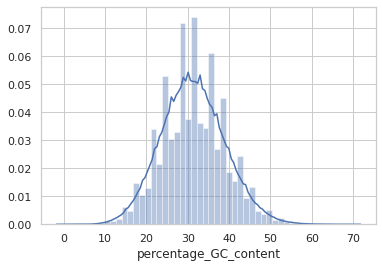

In [9]:
dist_plot = GC_content['percentage_GC_content']
#create figure with no transparency
dist_plot_fig = sns.distplot(dist_plot).get_figure()

In [38]:
def windows_coords(promoter_bed,promoter_no_5UTR,GC_content_df, genetype=False):
    """function to add the centre of each window corresponding to each window no. and return a lineplot"""
    #read in bed file
    promoter_df = pd.read_table(promoter_bed, sep='\t', header=None)
    col = ['chr','start','stop','AGI','dot1', 'strand','source','type','dot2','attributes']
    promoter_df.columns = col
    #add promoter length column
    promoter_df['length'] = promoter_df.stop-promoter_df.start
    #merge promoter_bed with overeage_df on AGI
    merged = pd.merge(GC_content_df, promoter_df, on='AGI',  how='left',suffixes=('','_wholeprom')) 
    #calculate longest promoter length
    length_of_longest_promoter = merged.length.max()
    #make columns integars
    merged = merged.astype({'stop_wholeprom':'int','start_wholeprom':'int','start':'int','stop':'int'})
    #split merged into 2 dfs by strand
    pos = merged[merged.strand == '+'].copy()
    neg = merged[merged.strand == '-'].copy()
    
    #add coverage position column where position is the middle of the window, with whole length of the longest promoter
    pos['position'] = (pos.stop_wholeprom) - (pos.start+0.5*(pos.stop-pos.start))
    neg['position'] = (neg.start+0.5*(neg.stop-neg.start)) - neg.start_wholeprom
    merged2 = pd.merge(pos,neg,how='outer')

    merged2 = merged2.astype({'position': 'int64'})
    #get longest transcript TSS distribution (if Araport 11 definition used)
    promoter_no_5UTR_df = pd.read_table(promoter_no_5UTR, sep='\t', header=None)
    col = ['chr', 'source', 'type', 'start','stop', 'dot1','strand','dot2','attributes']
    promoter_no_5UTR_df.columns = col
    #add AGI column
    promoter_no_5UTR_df_agi = promoter_no_5UTR_df.assign(AGI=promoter_no_5UTR_df.attributes.str.extract(r'ID=gene:(.*?)\;'))
    
    merged2 = pd.merge(merged2,promoter_no_5UTR_df_agi, on='AGI', how='left', suffixes=('','_no_UTR'))
    #remove NaN (promoters in promoters.gff but not in promoters_5UTR)
    merged2 = merged2[merged2.length.notnull()]
    #remove NaN (promoters in promoters_5UTR but not in promoters.gff - ie. only 5'UTRs)
    merged2 = merged2[merged2.chr_no_UTR.notnull()]

    #make 0 start like in bed files
    merged2.start_no_UTR = merged2.start_no_UTR -1
    #add TSS locationcolumn
    #merged2['TSS'] = int()
    merged2.loc[merged2.strand == '+', 'TSS'] = merged2.loc[merged2.strand == '+', 'stop_no_UTR']
    merged2.loc[merged2.strand == '-', 'TSS'] = merged2.loc[merged2.strand == '-', 'start_no_UTR'] -1
    #transform TSS location in the same way as the coverage position column
    merged2.loc[merged2.strand == '-', 'TSS_transformed'] = merged2.loc[merged2.strand == '-', 'TSS'] - merged2.loc[merged2.strand == '-','start_wholeprom']
    merged2.loc[merged2.strand == '+', 'TSS_transformed'] = merged2.loc[merged2.strand == '+', 'stop_wholeprom'] - merged2.loc[merged2.strand == '+', 'TSS']
    #make integars
    merged2 = merged2.astype({'start_no_UTR':'int','stop_no_UTR':'int','TSS':'int','TSS_transformed':'int'})
    #return merged2[['AGI','strand','start','stop','start_wholeprom','stop_wholeprom','start_no_UTR','stop_no_UTR','TSS','TSS_transformed','position','chr_no_UTR','window_number']]
    #make all values of interest negative as upstream from ATG
    merged_positive = merged2.copy()
    merged2[['length','TSS_transformed','position']] = -merged2[['length','TSS_transformed','position']]

    if genetype==False:
        #make subplots
        f, axes = plt.subplots(3, figsize=(10,8))
        length_of_longest_promoter = merged_positive.length.max()
        
        #TSS distribution
        sns.distplot(merged2.TSS_transformed, ax=axes[0])
        #promoter length dist_plot
        sns.distplot(merged2.length, ax=axes[1])

        #lineplot
        sns.lineplot(y=merged2.percentage_GC_content, x=merged2.position, ax=axes[2]) 
        #set titles
        axes[0].set_title(f'All promoters TSS distribution', weight='bold')
        #density is kernal density estimation
        axes[0].set_ylabel('Density')
        axes[0].set_xlabel('')
        axes[0].set_xticklabels([])
        axes[1].set_title(f'All promoters length distribution', weight='bold')  
        axes[1].set_ylabel('Density')
        axes[1].set_xlabel('')
        axes[1].set_xticklabels([])
        axes[2].set_title(f'All promoters sliding windows % GC content', weight='bold')
        axes[2].set_ylabel('mean % GC content')
        axes[2].set_xlabel('position upstream of ATG')

        
        #for all subplots:
        for n in axes:
            #remove grids
            n.grid(False)
            n.set_xlim([-length_of_longest_promoter,0])
            
            
            
        f.tight_layout()
               
    else:
        #filter so only genetype subset present
        merged2 = merged2[merged2.gene_type.notnull()]
        #make subplots
        f, axes = plt.subplots(3, figsize=(10,8))
        length_of_longest_promoter = merged_positive[merged_positive.gene_type.notnull()].length.max()
        
        #TSS distribution
        sns.distplot(merged2[merged2.gene_type == genetype].TSS_transformed, ax=axes[0])
        #promoter length dist_plot
        sns.distplot(merged2[merged2.gene_type == genetype].length, ax=axes[1])

        #lineplot
        sns.lineplot(y=merged2[merged2.gene_type == genetype].percentage_GC_content, x=merged2[merged2.gene_type == genetype].position, ax=axes[2]) 
        #set titles
        axes[0].set_title(f'{genetype} TSS distribution', weight='bold')
        #density is kernal density estimation
        axes[0].set_ylabel('Density')
        axes[0].set_xlabel('')
        axes[0].set_xticklabels([])
        axes[1].set_title(f'{genetype} promoter length distribution', weight='bold')  
        axes[1].set_ylabel('Density')
        axes[1].set_xlabel('')
        axes[1].set_xticklabels([])
        axes[2].set_title(f'{genetype} promoter sliding windows % GC content', weight='bold')
        axes[2].set_ylabel('mean % GC content')
        axes[2].set_xlabel('position upstream of ATG')
        #set y axis as maximum mean window % bp covered of all genetype subset        
        axes[2].set_ylim([merged2.groupby('window_number').percentage_GC_content.mean().min()-10,merged2.groupby('window_number').percentage_GC_content.mean().max()+10])
        
        
        #for all subplots:
        for n in axes:
            #remove grids
            n.grid(False)
            n.set_xlim([-length_of_longest_promoter,0])
            
            
            
        f.tight_layout()
               

    
    
    
    return merged2

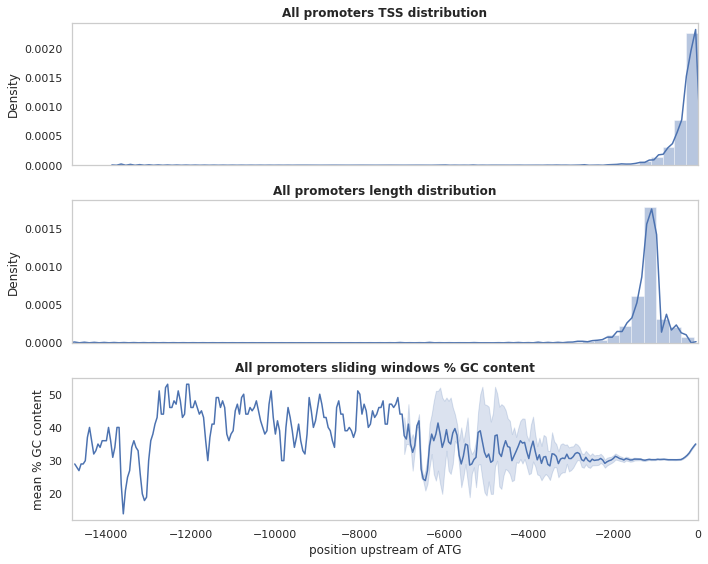

In [39]:
all_proms = windows_coords(promoter_bed,promoter_no_5UTR, GC_content)

## Now do constitutive and variable promoter from Czechowski et al 2005

In [40]:
def add_genetype(df,gene_categories):
    """function to add gene type to the df, and remove random genes"""
    select_genes = pd.read_table(gene_categories, sep='\t', header=None)
    cols = ['AGI', 'gene_type']
    select_genes.columns = cols

    merged = pd.merge(select_genes, df, on='AGI', how='left')   
   # no_random = merged_renamed[merged_renamed.gene_type != 'random']
  #  no_random.reset_index(drop=True, inplace=True)
    
    return merged

In [41]:
GC_prom_types = add_genetype(GC_content, Czechowski_gene_categories)

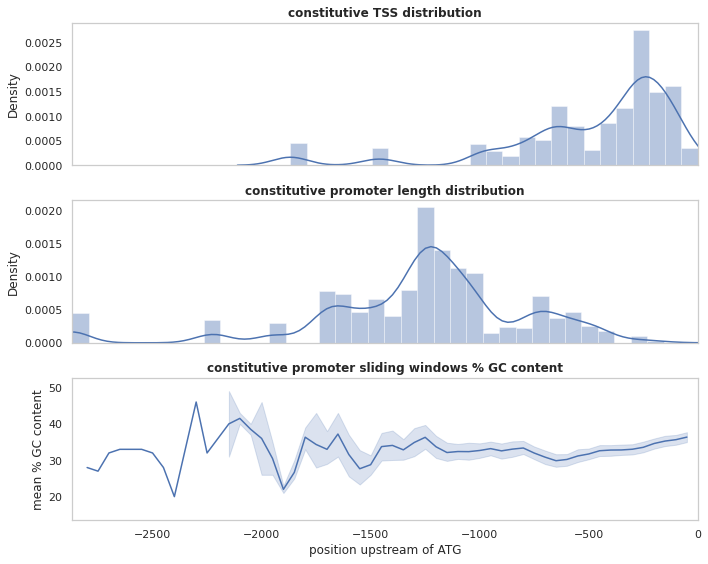

In [42]:
constitutive_rolling = windows_coords(promoter_bed,promoter_no_5UTR,GC_prom_types,genetype='constitutive')

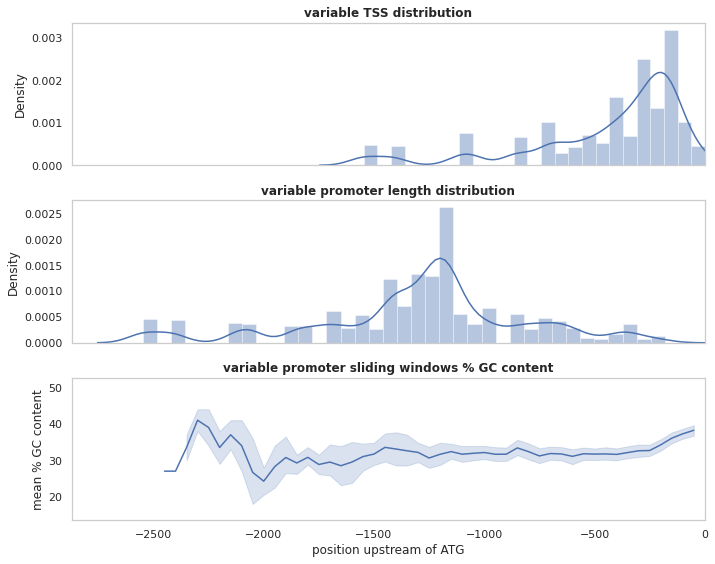

In [43]:
variable_rolling = windows_coords(promoter_bed,promoter_no_5UTR,GC_prom_types,genetype='variable')

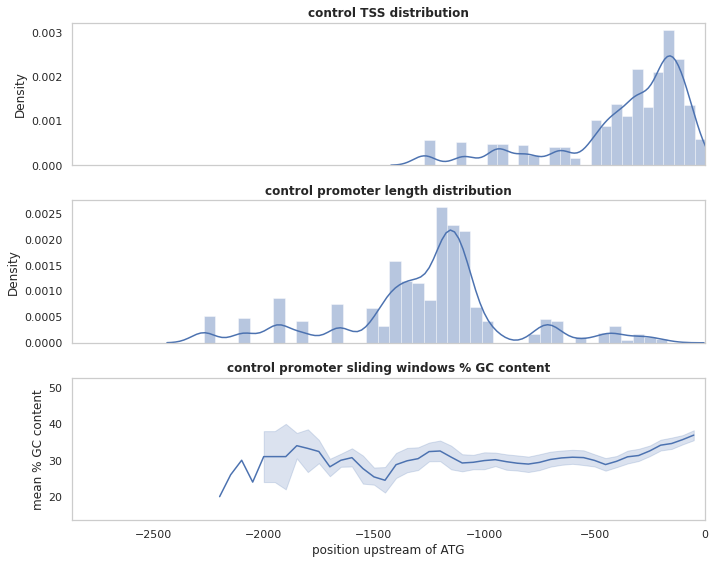

In [44]:
random_rolling = windows_coords(promoter_bed,promoter_no_5UTR,GC_prom_types,genetype='control')